In [1]:
import torch
from torch import nn

import torch.functional as F

from PIL import Image
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

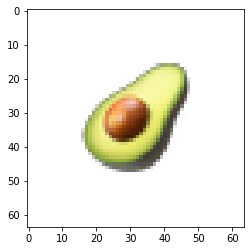

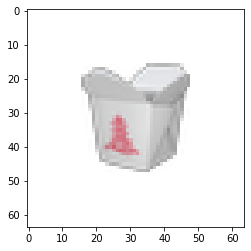

In [2]:
def load_image(url, max_size=32, padding=16):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)))
    
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).float().cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


avocado = load_emoji("🥑")
pineapple = load_emoji("🥡")

plt.imshow(avocado.transpose(0,2).cpu())
plt.show()
plt.imshow(pineapple.transpose(0,2).cpu())
plt.show()

img_size = 64

In [3]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3*self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.5

        return conved*can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]

        for i in range(iterations):

            x = x + self.perception(x)

            is_alive = nn.functional.max_pool2d(
                x[:, 3], (3, 3), stride=1, padding=1) > 1/8

            is_alive = is_alive.unsqueeze(1)

            x = x*is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x

        return x

In [4]:
n_channels = 16
n_epochs = 5000
lr = 0.001
pool_size = 1024
batch_size = 8

image_1 = avocado
image_2 = pineapple

model = Automata((64, 64), n_channels).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

pool_initials = seed[None, :].repeat(pool_size,1,1,1)
pool_targets = image_1[None,:].repeat(pool_size,1,1,1)
pool_target_ids = torch.ones(pool_size)

# 0 for seed, 1 for image_1, 2 for image_2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
#     iterations = random.randint(64,96)
    iterations = 100

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:batch_size//2]
    max_loss_indices = ranked_loss[batch_size//2:]
    
    # switch the min-loss samples
    
#     for swap_idx in min_loss_indices:
#         pool_idx = pool_indices[swap_idx]
#         target_id = int(pool_target_ids[pool_idx])
        
#         # if output is the first image,
#         # switch the target to the second
#         if target_id == 1:
#             pool_targets[pool_idx] = image_2
#             pool_target_ids[pool_idx] = 2

#         # if output is the second image,
#         # keep it
#         if target_id == 2:
#             pool_targets[pool_idx] = image_2
#             pool_target_ids[pool_idx] = 2
    
    replacements = out.detach()
    replacements[max_loss_indices] = seed.clone()
    
    # high-loss outputs are re-tasked with
    # mapping the seed to the first image,
    
    # low-loss outputs are tasked with mapping
    # the output to the second
    pool_targets[pool_indices[max_loss_indices]] = image_1
    pool_targets[pool_indices[min_loss_indices]] = image_2
    
    pool_target_ids[pool_indices[max_loss_indices]] = 1
    pool_target_ids[pool_indices[min_loss_indices]] = 2

    pool_initials[pool_indices] = replacements

    if i % 10 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -1.0723602581784166
10 -1.7305659109041862
20 -1.178826546741125
30 -1.3097991437724519
40 -1.8036048253911299
50 -1.5834951363316268
60 -1.5011498672185064
70 -1.524922101424103
80 -1.6756685988733528
90 -1.7561526119311737
100 -1.6255554224880875
110 -1.8509476325141236
120 -1.6678674110224432
130 -1.6698283520077746
140 -1.8673982916847027
150 -1.6416582780583073
160 -1.81513518227627
170 -1.890765191470524
180 -1.8350697655198636
190 -1.7703972174066418
200 -1.8400328346092336
210 -1.933926315591357
220 -1.5972071121085907
230 -1.8392834414430554
240 -1.752624988087132
250 -1.7640073534884688
260 -1.4011547092034502
270 -2.0673061022633354
280 -1.9934786712006922
290 -1.816439959557965
300 -2.1519872990762705
310 -2.0950888050038174
320 -1.8829690093479485
330 -2.034592259033973
340 -2.1712058151890856
350 -1.8857122306112684
360 -1.955716919521264
370 -2.036512144630623
380 -1.8246008076709963
390 -2.0538260893702884
400 -1.9373028912534682
410 -1.9152699901415047
420 -2.0352571

3390 -3.092594123755474
3400 -3.0839573966557134
3410 -3.074839906504934
3420 -3.03060012019041
3430 -3.0897587267947633
3440 -3.0723748969738947
3450 -2.9859300946153953
3460 -3.030452342969115
3470 -3.087405848654255
3480 -2.987163984271759
3490 -2.975098107203366
3500 -3.09039695690149
3510 -3.061051974911784
3520 -2.9343228278130637
3530 -2.942289418550362
3540 -2.9387870663149687
3550 -2.8591982024666533
3560 -3.0365533197644665
3570 -2.8633257643133545
3580 -3.0171458502450474
3590 -3.0750730281730774
3600 -2.921794850701531
3610 -2.9218257618998638
3620 -2.7726140374460853
3630 -3.0494589438566972
3640 -3.1088230299644644
3650 -3.103028765627972
3660 -3.076552961397557
3670 -2.9465890752966555
3680 -2.9689855859496626
3690 -3.0588537276042556
3700 -3.0403196779689075
3710 -3.0963304413155535
3720 -3.0746916269380082
3730 -3.040886636001156
3740 -3.137008615340389
3750 -3.1820374641304783
3760 -3.0802184173376816
3770 -3.10117436389788
3780 -3.010587748625596
3790 -3.085822270371

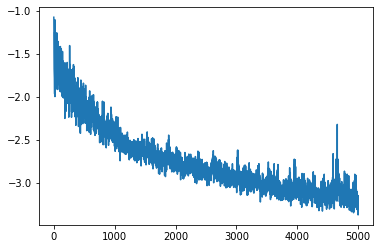

In [5]:
plt.plot(np.log10(losses))

In [6]:
pool_target_ids[:100]

tensor([1., 1., 1., 2., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1.,
        1., 2., 1., 1., 2., 2., 1., 1., 2., 1., 2., 1., 2., 1., 2., 2., 1., 1.,
        2., 1., 2., 1., 2., 2., 2., 2., 1., 2., 1., 2., 1., 2., 2., 2., 1., 2.,
        1., 2., 2., 1., 2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2.,
        1., 1., 1., 2., 2., 2., 2., 2., 1., 2.])

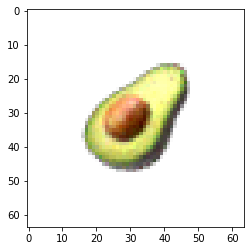

In [7]:
plt.imshow(pool_initials[16,:4].transpose(0,2).cpu())

In [8]:
out = model(seed[None,:],512,keep_history=True).squeeze()

In [9]:
video = model.history.cpu().detach()
video = video[:,0,:4]
video = video.transpose(1,3)

In [10]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())